<a href="https://colab.research.google.com/github/belovelace/AI-study/blob/main/UCI_HAR_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, Conv1D, BatchNormalization, ReLU, MaxPooling1D, GlobalAveragePooling1D, SimpleRNN
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau # Import ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

### 데이터 로딩

In [13]:
# 파일 가져오기
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
INPUT_SIGNAL_TYPES = [
    "body_acc_x_",
    "body_acc_y_",
    "body_acc_z_",
    "body_gyro_x_",
    "body_gyro_y_",
    "body_gyro_z_",
    "total_acc_x_",
    "total_acc_y_",
    "total_acc_z_"
]

LABELS = [
    "WALKING",
    "WALKING_UPSTAIRS",
    "WALKING_DOWNSTAIRS",
    "SITTING",
    "STANDING",
    "LAYING"
]

In [15]:
TRAIN = "train/"
TEST = "test/"

DATASET_PATH = "/content/drive/MyDrive/AI_study/UCI HAR Dataset/"

#===데이터 전체 저장===
def load_X(X_signals_paths):
    X_signals = []

    for signal_type_path in X_signals_paths:
        series_list = []

        with open(signal_type_path, 'r') as file:
            for row in file:
                row_clean = row.replace('  ', ' ') # 공백 2개를 1개로
                row_clean = row_clean.strip() # 양쪽 공백 제거
                serie = row_clean.split(' ') # 공백 기준 split
                serie_array = np.array(serie, dtype=np.float32) # float32 numpy 배열로 변환
                series_list.append(serie_array) # 시퀀스 추가

        # 하나의 센서축 데이터 추가 (feature)
        X_signals.append(series_list)

    # ===형태 변환===
    # shape: (특성 수, 샘플 수, 타임스텝 수)
    X_signals = np.array(X_signals)
    # shape 변환 → (샘플 수, 타임스텝 수, 특성 수)
    return np.transpose(X_signals, (1, 2, 0))


X_train_signals_paths = [
    DATASET_PATH + TRAIN + "Inertial Signals/" + signal + "train.txt"
    for signal in INPUT_SIGNAL_TYPES
]
X_test_signals_paths = [
    DATASET_PATH + TEST + "Inertial Signals/" + signal + "test.txt"
    for signal in INPUT_SIGNAL_TYPES
]

X_train = load_X(X_train_signals_paths)
X_test = load_X(X_test_signals_paths)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("첫 번째 샘플 데이터:\n", X_train[0])

X_train shape: (7352, 128, 9)
X_test shape: (2947, 128, 9)
첫 번째 샘플 데이터:
 [[ 1.808515e-04  1.076681e-02  5.556068e-02 ...  1.012817e+00
  -1.232167e-01  1.029341e-01]
 [ 1.013856e-02  6.579480e-03  5.512483e-02 ...  1.022833e+00
  -1.268756e-01  1.056872e-01]
 [ 9.275574e-03  8.928878e-03  4.840473e-02 ...  1.022028e+00
  -1.240037e-01  1.021025e-01]
 ...
 [-1.147484e-03  1.714439e-04  2.647864e-03 ...  1.018445e+00
  -1.240696e-01  1.003852e-01]
 [-2.222655e-04  1.574181e-03  2.381057e-03 ...  1.019372e+00
  -1.227451e-01  9.987355e-02]
 [ 1.575500e-03  3.070189e-03 -2.269757e-03 ...  1.021171e+00
  -1.213260e-01  9.498741e-02]]


###  Simple RNN 모델 구축

In [16]:
print("\n" + "="*60)
print("Simple RNN 모델 구축")
print("="*60)

input_shape = (X_train.shape[1], X_train.shape[2])  # (128, 9)
num_classes = 6

rnn_model = Sequential([
    Input(shape=input_shape),

    # RNN 레이어 1
    SimpleRNN(64, return_sequences=True),
    Dropout(0.3),

    # RNN 레이어 2
    SimpleRNN(128, return_sequences=True),
    Dropout(0.3),

    # RNN 레이어 3
    SimpleRNN(64),
    Dropout(0.3),

    # 완전연결층
    Dense(64, activation='relu'),
    Dropout(0.2),

    # 출력층
    Dense(num_classes, activation='softmax')
], name='SimpleRNN_Model')

# 모델 컴파일
rnn_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)

print("\n 모델 구조:")
rnn_model.summary()


Simple RNN 모델 구축

 모델 구조:


Model: "SimpleRNN_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 128, 64)        │         4,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 128, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_2 (SimpleRNN)        │ (None, 64)             │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,342 (181.02 KB)

 Trainable params: 46,342 (181.02 KB)

 Non-trainable params: 0 (0.00 B)

### 콜백 설정

In [19]:
print("\n" + "="*60)
print("콜백 함수 설정")
print("="*60)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=7,
    min_lr=1e-6,
    verbose=1
)

checkpoint = ModelCheckpoint(
    'best_rnn_model.h5',
    monitor='val_sparse_categorical_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

callbacks = [early_stopping, reduce_lr, checkpoint]

print("✓ EarlyStopping: patience=15")
print("✓ ReduceLROnPlateau: patience=7")
print("✓ ModelCheckpoint: 최고 성능 모델 저장")


콜백 함수 설정
✓ EarlyStopping: patience=15
✓ ReduceLROnPlateau: patience=7
✓ ModelCheckpoint: 최고 성능 모델 저장


### 모델 학습

In [21]:
# ===레이블 전체 저장===
def load_y(y_path):
    y = []
    with open(y_path, 'r') as file:
        for row in file:
            y.append(int(row.strip()) - 1) # 활동 레이블은 1부터 시작하므로 0부터 시작하도록 -1

    return np.array(y)

y_train_path = DATASET_PATH + TRAIN + "y_train.txt"
y_test_path = DATASET_PATH + TEST + "y_test.txt"

y_train = load_y(y_train_path)
y_test = load_y(y_test_path)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)
print("첫 번째 샘플 레이블:\n", y_train[0])

y_train shape: (7352,)
y_test shape: (2947,)
첫 번째 샘플 레이블:
 4


In [22]:
print("\n" + "="*60)
print("RNN 모델 학습 시작")
print("="*60)

batch_size = 64
epochs = 100

history = rnn_model.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_test, y_test),
    callbacks=callbacks,
    verbose=1
)


RNN 모델 학습 시작
Epoch 1/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - loss: 1.3388 - sparse_categorical_accuracy: 0.4364
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.59213, saving model to best_rnn_model.h5


115/115 ━━━━━━━━━━━━━━━━━━━━ 28s 205ms/step - loss: 1.3364 - sparse_categorical_accuracy: 0.4373 - val_loss: 0.8624 - val_sparse_categorical_accuracy: 0.5921 - learning_rate: 0.0010
Epoch 2/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - loss: 0.8454 - sparse_categorical_accuracy: 0.5935
Epoch 2: val_sparse_categorical_accuracy improved from 0.59213 to 0.62708, saving model to best_rnn_model.h5


115/115 ━━━━━━━━━━━━━━━━━━━━ 20s 175ms/step - loss: 0.8454 - sparse_categorical_accuracy: 0.5935 - val_loss: 0.7756 - val_sparse_categorical_accuracy: 0.6271 - learning_rate: 0.0010
Epoch 3/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.7078 - sparse_categorical_accuracy: 0.6561
Epoch 3: val_sparse_categorical_accuracy improved from 0.62708 to 0.65490, saving model to best_rnn_model.h5


115/115 ━━━━━━━━━━━━━━━━━━━━ 21s 187ms/step - loss: 0.7077 - sparse_categorical_accuracy: 0.6562 - val_loss: 0.8032 - val_sparse_categorical_accuracy: 0.6549 - learning_rate: 0.0010
Epoch 4/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 0.6700 - sparse_categorical_accuracy: 0.6909
Epoch 4: val_sparse_categorical_accuracy improved from 0.65490 to 0.70105, saving model to best_rnn_model.h5


115/115 ━━━━━━━━━━━━━━━━━━━━ 19s 167ms/step - loss: 0.6698 - sparse_categorical_accuracy: 0.6910 - val_loss: 0.8690 - val_sparse_categorical_accuracy: 0.7011 - learning_rate: 0.0010
Epoch 5/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 0.6122 - sparse_categorical_accuracy: 0.7199
Epoch 5: val_sparse_categorical_accuracy did not improve from 0.70105
115/115 ━━━━━━━━━━━━━━━━━━━━ 19s 169ms/step - loss: 0.6119 - sparse_categorical_accuracy: 0.7200 - val_loss: 0.9344 - val_sparse_categorical_accuracy: 0.6970 - learning_rate: 0.0010
Epoch 6/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.6510 - sparse_categorical_accuracy: 0.7293
Epoch 6: val_sparse_categorical_accuracy improved from 0.70105 to 0.72447, saving model to best_rnn_model.h5


115/115 ━━━━━━━━━━━━━━━━━━━━ 22s 187ms/step - loss: 0.6506 - sparse_categorical_accuracy: 0.7294 - val_loss: 0.6336 - val_sparse_categorical_accuracy: 0.7245 - learning_rate: 0.0010
Epoch 7/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 0.6012 - sparse_categorical_accuracy: 0.7344
Epoch 7: val_sparse_categorical_accuracy improved from 0.72447 to 0.74041, saving model to best_rnn_model.h5


115/115 ━━━━━━━━━━━━━━━━━━━━ 19s 166ms/step - loss: 0.6016 - sparse_categorical_accuracy: 0.7343 - val_loss: 0.5642 - val_sparse_categorical_accuracy: 0.7404 - learning_rate: 0.0010
Epoch 8/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - loss: 0.5114 - sparse_categorical_accuracy: 0.7586
Epoch 8: val_sparse_categorical_accuracy did not improve from 0.74041
115/115 ━━━━━━━━━━━━━━━━━━━━ 22s 181ms/step - loss: 0.5118 - sparse_categorical_accuracy: 0.7583 - val_loss: 0.7545 - val_sparse_categorical_accuracy: 0.6210 - learning_rate: 0.0010
Epoch 9/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 0.6585 - sparse_categorical_accuracy: 0.6663
Epoch 9: val_sparse_categorical_accuracy did not improve from 0.74041
115/115 ━━━━━━━━━━━━━━━━━━━━ 19s 165ms/step - loss: 0.6584 - sparse_categorical_accuracy: 0.6663 - val_loss: 0.7179 - val_sparse_categorical_accuracy: 0.6508 - learning_rate: 0.0010
Epoch 10/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - loss: 0.6293 - sparse_categorical_accura

### 모델 평가

In [23]:
print("\n" + "="*60)
print("모델 평가")
print("="*60)

# 테스트 데이터 평가
test_loss, test_acc = rnn_model.evaluate(X_test, y_test, verbose=0)
print(f"\n✓ Test Accuracy: {test_acc*100:.2f}%")
print(f"✓ Test Loss: {test_loss:.4f}")

# 훈련 데이터 평가
train_loss, train_acc = rnn_model.evaluate(X_train, y_train, verbose=0)
print(f"✓ Train Accuracy: {train_acc*100:.2f}%")
print(f"✓ Train Loss: {train_loss:.4f}")


모델 평가

✓ Test Accuracy: 74.04%
✓ Test Loss: 0.5642
✓ Train Accuracy: 78.79%
✓ Train Loss: 0.4549


### 에측 및 분류 리포트

In [24]:
print("\n" + "="*60)
print("상세 분류 리포트")
print("="*60)

y_pred = rnn_model.predict(X_test, verbose=0)
y_pred_classes = np.argmax(y_pred, axis=1)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes, target_names=LABELS))



상세 분류 리포트

Classification Report:
                    precision    recall  f1-score   support

           WALKING       0.50      0.88      0.64       496
  WALKING_UPSTAIRS       0.61      0.14      0.23       471
WALKING_DOWNSTAIRS       0.80      0.81      0.80       420
           SITTING       0.90      0.67      0.77       491
          STANDING       0.76      0.92      0.83       532
            LAYING       0.99      0.97      0.98       537

          accuracy                           0.74      2947
         macro avg       0.76      0.73      0.71      2947
      weighted avg       0.76      0.74      0.72      2947



### 혼동 행렬 시각화


혼동 행렬 생성


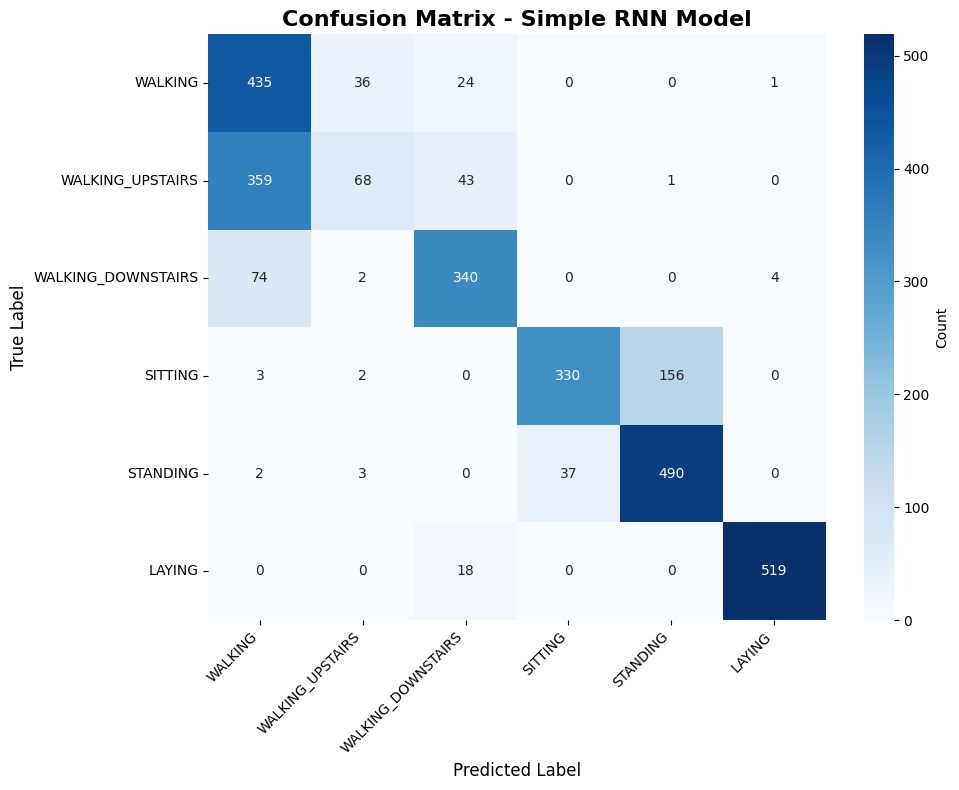

✓ 혼동 행렬 생성 완료


In [25]:
print("\n" + "="*60)
print("혼동 행렬 생성")
print("="*60)

cm = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=LABELS, yticklabels=LABELS,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Simple RNN Model', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("✓ 혼동 행렬 생성 완료")

### 학습 과정 시각화


학습 과정 시각화


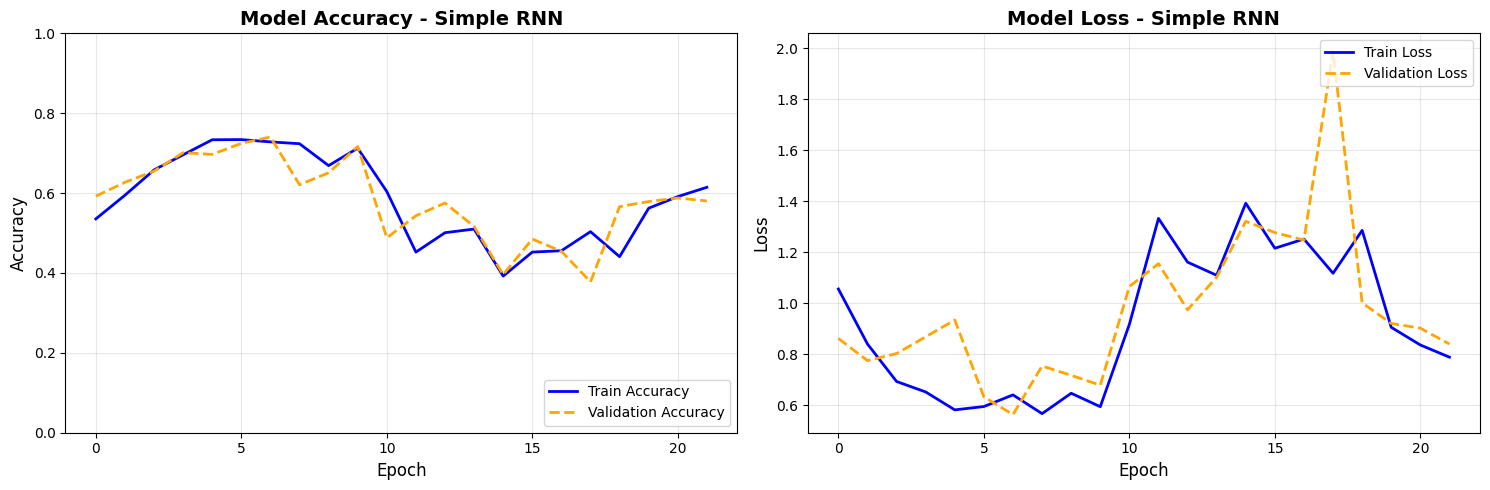

✓ 학습 과정 그래프 생성 완료


In [26]:
print("\n" + "="*60)
print("학습 과정 시각화")
print("="*60)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy 그래프
axes[0].plot(history.history['sparse_categorical_accuracy'],
             label='Train Accuracy', linewidth=2, color='blue')
axes[0].plot(history.history['val_sparse_categorical_accuracy'],
             label='Validation Accuracy', linewidth=2, linestyle='--', color='orange')
axes[0].set_title('Model Accuracy - Simple RNN', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].legend(loc='lower right', fontsize=10)
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim([0, 1])

# Loss 그래프
axes[1].plot(history.history['loss'],
             label='Train Loss', linewidth=2, color='blue')
axes[1].plot(history.history['val_loss'],
             label='Validation Loss', linewidth=2, linestyle='--', color='orange')
axes[1].set_title('Model Loss - Simple RNN', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].legend(loc='upper right', fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ 학습 과정 그래프 생성 완료")

### 클래스별 정확도 분석


클래스별 정확도 분석
WALKING             :  87.70%
WALKING_UPSTAIRS    :  14.44%
WALKING_DOWNSTAIRS  :  80.95%
SITTING             :  67.21%
STANDING            :  92.11%
LAYING              :  96.65%


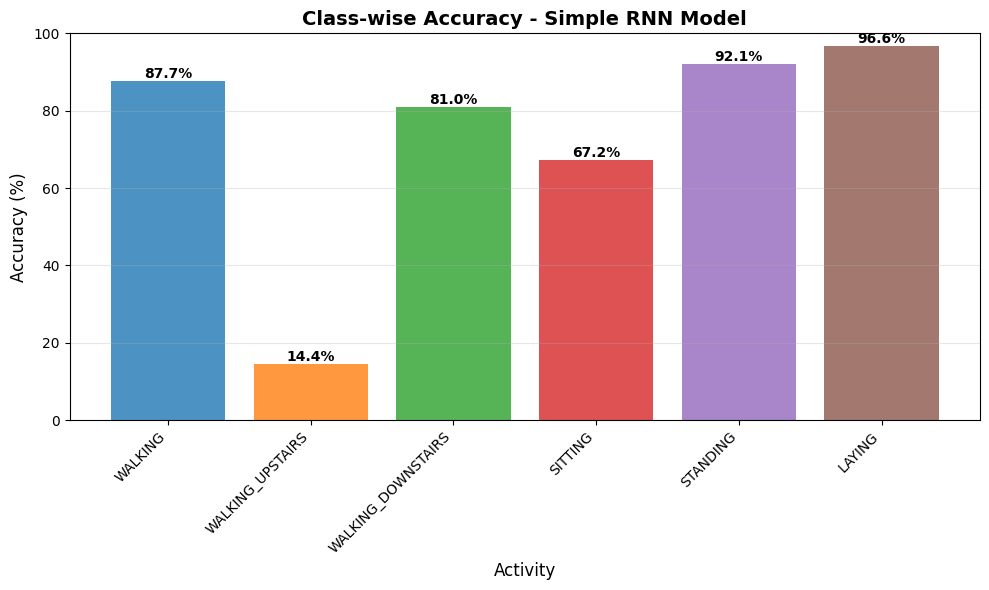

✓ 클래스별 정확도 그래프 생성 완료


In [27]:
print("\n" + "="*60)
print("클래스별 정확도 분석")
print("="*60)

class_accuracy = []
for i in range(num_classes):
    mask = y_test == i
    if mask.sum() > 0:
        acc = (y_pred_classes[mask] == y_test[mask]).mean()
        class_accuracy.append(acc)
        print(f"{LABELS[i]:20s}: {acc*100:6.2f}%")

# 클래스별 정확도 막대 그래프
plt.figure(figsize=(10, 6))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
bars = plt.bar(LABELS, [acc*100 for acc in class_accuracy], color=colors, alpha=0.8)
plt.title('Class-wise Accuracy - Simple RNN Model', fontsize=14, fontweight='bold')
plt.xlabel('Activity', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.ylim([0, 100])
plt.grid(True, alpha=0.3, axis='y')

# 막대 위에 정확도 표시
for bar, acc in zip(bars, class_accuracy):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{acc*100:.1f}%',
             ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("✓ 클래스별 정확도 그래프 생성 완료")

### 예측 샘플 확인

In [28]:
print("\n" + "="*60)
print("예측 샘플 확인 (처음 10개)")
print("="*60)

for i in range(10):
    true_label = y_test[i]
    pred_label = y_pred_classes[i]
    confidence = y_pred[i][pred_label] * 100

    status = "✓" if true_label == pred_label else "✗"

    print(f"\n샘플 {i+1:2d}: {status}")
    print(f"  실제: {LABELS[true_label]:20s}")
    print(f"  예측: {LABELS[pred_label]:20s} (확신도: {confidence:5.1f}%)")


예측 샘플 확인 (처음 10개)

샘플  1: ✓
  실제: STANDING            
  예측: STANDING             (확신도:  92.2%)

샘플  2: ✓
  실제: STANDING            
  예측: STANDING             (확신도:  92.2%)

샘플  3: ✓
  실제: STANDING            
  예측: STANDING             (확신도:  92.3%)

샘플  4: ✓
  실제: STANDING            
  예측: STANDING             (확신도:  92.2%)

샘플  5: ✓
  실제: STANDING            
  예측: STANDING             (확신도:  92.2%)

샘플  6: ✓
  실제: STANDING            
  예측: STANDING             (확신도:  92.3%)

샘플  7: ✓
  실제: STANDING            
  예측: STANDING             (확신도:  92.4%)

샘플  8: ✓
  실제: STANDING            
  예측: STANDING             (확신도:  92.3%)

샘플  9: ✓
  실제: STANDING            
  예측: STANDING             (확신도:  92.3%)

샘플 10: ✓
  실제: STANDING            
  예측: STANDING             (확신도:  92.3%)


### 최종 요약

In [30]:
print("\n" + "="*60)
print("Simple RNN 모델 학습 완료!")
print("="*60)
print(f"최종 테스트 정확도: {test_acc*100:.2f}%")
print(f"총 에포크: {len(history.history['loss'])}")
print(f"모델 저장: best_rnn_model.h5")
print("="*60)


Simple RNN 모델 학습 완료!
최종 테스트 정확도: 74.04%
총 에포크: 22
모델 저장: best_rnn_model.h5
